# BMI 203 HW1
## Parker Grosjean
------

In [1]:
# Importing all necessary dependencies

# other packages
import numpy as np
import pandas as pd
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# my module
from align import algs


# **Part 1**
---------

# Question 1

The parameters and variables thare are needed for the algoritm initiation, execution, and termination are as follows:

## a
**initiation**
During the initalization the algorithms require the instantiation of all of variables used during the actual execution of the alignments.

1) Substitution Matrix (holds the information used for scoring matches and mismatches)

2) The three scoring matrices (main or core scoring matrix S, gap in sequence 1 matrix Y, and gap in sequence 2 matrix X)

3) Traceback matrix (matrix used to point to previous highest element in the core scoring matrix for each step)

4) The protein residue sequences for alignment must be read in as variables from the fasta files

5) gap penalty scheme (gap-opening and gap-extention variables)

**execution**
The execeution is primarily just filling in the score matrices and traceback matrix based on the variables from initailization and then tracing back through the traceback matrix to get the alignment. The important new variables are the alignment and alignment score variables, where alignment contains both the alignment for a sequence 1 and sequence 2 and the alignment score corresponds to the alignment score, which is dependent on the algorithm (for smith waterman max element in the score matrix and for needleman wunsch the last element in the array)

1) alignmment (string of sequence 1 and sequence 2 alignments)

2) alignment score (score of alignment from algorithm)

**termination**
The main variable needed for termination is the stop condition during traceback in the two different algorithms. In the case of SmithWaterman the stop condition is reaching the first index of either sequence or finding a zero while tracing back (local alignment), in the case of NeedlemanWunsch the stop condition is reaching the first index of either sequence (global alignment).

## b
The quantities that are returned are the alignments for sequence 1 and sequence 2 and then in my implementation the alignment score is accessible via a class attribute.

## c
The runtime for the dynamic programming matrix filling is O(nm) where n and m are the length of sequence 1 and sequence 2 for alignment, respectively. The dynamic programming is the rate limiting step in this algorithm, as the traceback process is the order of the length of the aligned sequences.

# Question 2

**Shared**
- Reading in fasta files
- Reading in the substitution matrix
- Initializing scoring matrices (3 matrices total all of shape len(seq1)+1 X len(seq2)+1)
- Initializing traceback matrix

**Not Shared**
- Post-initialization modification of scoring matrices (first row and column modification)
- Filling in scoring matrix (dynamic programming)
- Traceback (different based on the stop condition)

# Question 3

The main differnece between an affine-gap and linear-gap alignment implementation is the number of scoring matrices neccessary and the scoring scheme. In the case of the the linear-gap alignment there is only one gap penalty that is constant with no regard for the context of the gap, whereas in the affine-gap there is a gap opening and a gap extension penalty, allowing tunability to the extent to which large indels vs small indels are expected. In terms of the actual dynamic programming component the linear-gap only requires one matrix, because there is a diagnol move for match or mismatch and then down or right for a gap in one of the sequences. However, in the affine-gap setup there are two possible gap types a gap opening or a gap extention, which results in the need of one matrix for each of sequences just for storing whether that element in the alignment is an gap opening or a gap extension. Thus in the linear-gap you can just move through one scoring matrix, but in the affine-alignment you can think of it as jumping between the 3 matrices, although only one traceback array is required. You can see my code fore exactly how this is implemented.

# Question 4

See my SPHINX docs for the API documentation

# Question 5

I implemented the overlap alignment for the NeedlemanWunsch algorithm and this is all documented in my SPHINX API docs. There is also a unit test for this functionality.

# **Part 2**
---------
**Note**: When I refer to all of my gap penalties I refer to them as positive values, but they are being subtracted during the actual algorithms.

## Writing Helper Functions for **Part 2**

In [4]:
def read_pairs(neg_filename, pos_filename):
    '''
    Reads in negative pairs from the .txt file
    and loads them into a pandas dataframe for
    use when evaluating classification.
    
    Args
    ----
    neg_filename (str): Filename and path for negative pairs text file
    pos_filename (str): Filename and path for positive pairs text file
    
    Returns
    -------
    pair_df (pandas DataFrame): DataFrame with columns ['pair_1', 
        'pair_2', 'label'] corresponding to the first item in a pair
        the second item in a pair and the label of the pair (pos or neg)
        for all pairs.
    '''
    # Reading in negative pairs
    with open(neg_filename, 'r') as f:
        pair = [line.strip().split(' ') for line in f]
        pair_1_neg = np.array([p[0] for p in pair])
        pair_2_neg = np.array([p[1] for p in pair])
        label_neg = np.zeros(pair_1_neg.shape)
    # Reading in positive pairs
    with open(pos_filename, 'r') as f:
        pair = [line.strip().split(' ') for line in f]
        pair_1_pos = np.array([p[0] for p in pair])
        pair_2_pos = np.array([p[1] for p in pair])
        label_pos = np.ones(pair_1_pos.shape)
    
    # Stacking for DataFrame generation
    pair_1 = np.hstack([pair_1_neg, pair_1_pos])
    pair_2 = np.hstack([pair_2_neg, pair_2_pos])
    label = np.hstack([label_neg, label_pos])
    # generating DataFrame
    pair_df = pd.DataFrame({'pair_1': pair_1, 'pair_2': pair_2, 'label': label})
    return pair_df

def generate_aligner_sw(sub_mat_file, gap_open, gap_extend):
    '''
    This function generates an instance of the algs.SmithWaterman class.
    The resulting aligner can be used for classification.
    
    Args
    ----
    sub_mat_file (str): path/filename of substitution matrix
    gap_open (float): gap opening penalty
    gap_extend (float): gap extension penalty
    
    Returns
    -------
    sw_aligner (algs SmithWaterman): Instance of SmithWaterman class from algs
    '''
    sw_aligner = algs.SmithWaterman(sub_mat_file, gap_open, gap_extend)
    return sw_aligner

def generate_aligner_nw(sub_mat_file, gap_open, gap_extend):
    '''
    This function generates an instance of the algs.NeedlemanWunsch class.
    The resulting aligner can be used for classification.
    
    Args
    ----
    sub_mat_file (str): path/filename of substitution matrix
    gap_open (float): gap opening penalty
    gap_extend (float): Gap extension penalty
    
    Returns
    -------
    nw_aligner (algs NeedlemanWunsch): Instance of NeedlemanWunsch class from algs
    '''
    nw_aligner = algs.NeedlemanWunsch(sub_mat_file, gap_open, gap_extend)
    return nw_aligner
    
class Classifier():
    '''
    This class acts a classifier for positive and negative aligments.
    
    Parameters
    ----------
    aligner (algs NeedlemanWunsch or SmithWaterman): Alignment algorithm class instance
    pair_df (pandas DataFrame): DataFrame with columns ['pair_1', 
        'pair_2', 'label'] corresponding to the first item in a pair
        the second item in a pair and the label of the pair (pos or neg)
        for all pairs.
    
    Optional Parameters
    -------------------
    return_alignment (bool): Whether or not to return the alignment
        from the resulting aligner class instance if True then the 
        alignment is returned and if False then None is returned.
        
    Attributes
    ----------
    confusion_matrix_ (np array): confusion matrix for classification
    roc_ (list of np array): list of format [false_pos_rate, true_pos_rate, thresholds]
        where each of the elements in the list is a numpy array that spans from 0 to 1
        the first two of the elements correspond to the x and y axis of an roc plot
        respectively
    roc_auc_score_ (float): Area under the curve of the roc curve
    thresh_ (float): The mean alignment score used as a base threshold for binary
        classification
    '''
    def __init__(self, aligner, pair_df, return_alignment=True):
        self._aligner = aligner
        self._pair_df = pair_df
        self._return_alignment = return_alignment
        
    def run_classification(self):
        '''
        This function runs the classification for all pairs
        of protein sequences. This also generates the
        alignment_scores_ and thresh_ attributes
        as well as the roc_ and roc_auc_score_ attributes.
        
        Args
        ----
        None
        
        Returns
        -------
        None
        
        '''
        alignment_scores = []
        for pair_1, pair_2 in tqdm(zip(pair_df['pair_1'].values, pair_df['pair_2'].values)):
            aligner = self._aligner
            aligner.align(pair_1, pair_2, return_alignment=self._return_alignment)
            alignment_scores.append(aligner.align_score_)
        alignment_scores = np.array(alignment_scores)
        self._alignment_scores = alignment_scores
        thresh = np.mean(alignment_scores)
        self.thresh_ = thresh
        y_hat = (alignment_scores)/np.amax(alignment_scores)
        y_hat_cm = (alignment_scores > thresh).astype('float')
        y = pair_df['label']
        self.confusion_matrix_ = metrics.confusion_matrix(y, y_hat_cm)
        self.roc_ = metrics.roc_curve(y, y_hat)
        self.roc_auc_ = metrics.auc(self.roc_[0], self.roc_[1])
        self.roc_auc_score_ = metrics.roc_auc_score(y, y_hat)
    
    def plot_roc(self):
        '''
        This method plots the roc curve for the binary classifier using
        a pairwise alignment algorithm.
        
        Args
        ----
        None
        
        Returns
        -------
        None
        '''
        fpr, tpr, _ = self.roc_
        df = pd.DataFrame({'False Positive Rate': fpr, 'True Positive Rate': tpr})
        sns.lineplot(data=df, x='False Positive Rate', y='True Positive Rate')
        sns.lineplot(x=np.linspace(0, 1, 100), y=np.linspace(0, 1, 100), markers='-')
        plt.xlim((0, 1))
        plt.ylim((0, 1))
        plt.legend(['ROC', 'Random Chance Curve'])
#         plt.title(f'ROC Curve [Gap Open Penalty: {self._aligner.gap_open}, Gap Extension Penalty: {self._aligner.gap_extend}]')
        plt.show()
        
    def plot_alignment_distribution(self):
        '''
        This method plots the distribution of alignment scores
        using a kernel density approximation function.
        
        Args
        ----
        None
        
        Reurns
        ------
        None
        '''
        sns.kdeplot(x=self._alignment_scores, fill=True, clip=[0, np.amax(self._alignment_scores)])
        plt.xlabel('Alignment Score')
        plt.ylabel('Frequency')
        plt.show()
        
    

# Question 1

0it [00:00, ?it/s]

Generating Aligner
Generating Classifier


100it [01:13,  1.37it/s]


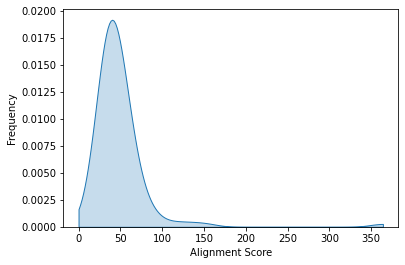

In [6]:
# Reading in Pairs
pair_df = read_pairs('./scoring_matrices/Negpairs.txt', './scoring_matrices/Pospairs.txt')
# Local Alignment (SmithWaterman)
print('Generating Aligner')
sw_aligner = generate_aligner_sw('./scoring_matrices/BLOSUM50.mat', 11, 3)
print('Generating Classifier')
sw_classifier = Classifier(sw_aligner, pair_df, return_alignment=False)
# Plotting distribution of alignment scores
sw_classifier.run_classification()
sw_classifier.plot_alignment_distribution()

The distribution of alignments looks like there is a small population (1) of alignments with a very high alignment score, but the majority of which fall within a somewhat normal looking distribution with high kurtosis (right skew).

# Question 2

Threshold --> 49.13 

Confusion Matrix 
---------------- 



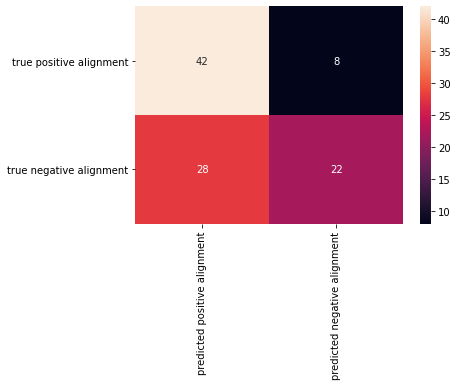

In [28]:
# Generating the confusion matrix
print(f'Threshold --> {sw_classifier.thresh_} \n')
print(f'Confusion Matrix \n---------------- \n')

sns.heatmap(sw_classifier.confusion_matrix_, 
            annot=True, 
            xticklabels=['predicted positive alignment', 'predicted negative alignment'], 
            yticklabels=['true positive alignment', 'true negative alignment'])
plt.show()

The threshold that was found was 49.12, which is the average alignment score.

This confusion matrix suggests that this threshold is relatively bad for binary classification, as there are a large number of false negative alignments. A good binary classifier would have a high true positve rate and a low false negative rate, which is not observed in this case. An ideal confusion matrix would have all the 50 along the diagnol and zero in the bottom left and top right elements. There is slightly more nuance to it, because this could be a good classifier if one were to want a classifier with a low false positive rate (e.i. if the auther were going to run wetlab experiments based on the results), but this would be a poor classifier if one were to want a higher false positive rate in order to catch all of true positives as would be the case in a high-throughput discovery setting. So overall I would classify this threshold as not great, but dependent on the research context.

# Question 3

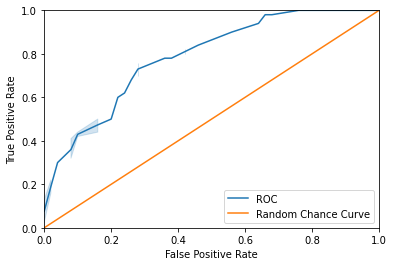

In [12]:
# Plotting the ROC Curve
sw_classifier.plot_roc()

# Question 4

In [13]:
# Determining Area Under the Curve
print(f'AUROC --> {sw_classifier.roc_auc_score_}')

AUROC --> 0.7858


This value suggests that the classifier performs better than by random chance, as in the binary classification task there is a 0.5 chance of getting the correct prediction by chance. The higher the value the better the overall performance of the binary classifier. Thus, this classifier does work, but one cannot determine the efficacy of this algorithm from the AUROC alone, because the AUROC simply describes the area under the reciever operator characteristic curve, which is a good proxy for the trade off of true positive rate and false positive rate and thus overall efficacy of classification, but is agnostic regarding the context for which the classifier is going to be used. Thus, the researcher must decide what the algorithm is going to be used for (discovery science vs wet-lab validation as I talked about above in question 2) and then decide if the performance is well suited for the specific research context.

# Question 5

In [14]:
# auroc = []
# gap_penalties = []
# for gap_open in range(1, 21):
#     for gap_extend in range(1, 6):
#         sw_aligner = generate_aligner_sw('./scoring_matrices/BLOSUM62.mat', gap_open, gap_extend)
#         sw_classifier = Classifier(sw_aligner, pair_df, return_alignment=False)
#         sw_classifier.run_classification()
#         auroc.append(sw_classifier.roc_auc_score_)
#         gap_penalties.append((gap_open, gap_extend))

100it [01:11,  1.40it/s]
100it [01:11,  1.40it/s]
100it [01:10,  1.42it/s]
100it [01:11,  1.40it/s]
100it [01:10,  1.41it/s]
100it [01:12,  1.38it/s]
100it [01:11,  1.40it/s]
100it [01:10,  1.42it/s]
100it [01:11,  1.39it/s]
100it [01:11,  1.40it/s]
100it [01:10,  1.41it/s]
100it [01:11,  1.39it/s]
100it [01:12,  1.39it/s]
100it [01:13,  1.36it/s]
100it [01:12,  1.38it/s]
100it [01:12,  1.39it/s]
100it [01:12,  1.38it/s]
100it [01:13,  1.37it/s]
100it [01:14,  1.35it/s]
100it [01:14,  1.34it/s]
100it [01:12,  1.37it/s]
100it [01:12,  1.38it/s]
100it [01:10,  1.42it/s]
100it [01:10,  1.42it/s]
100it [01:15,  1.32it/s]
100it [01:14,  1.34it/s]
100it [01:14,  1.35it/s]
100it [01:13,  1.36it/s]
100it [01:13,  1.35it/s]
100it [01:12,  1.37it/s]
100it [01:12,  1.39it/s]
100it [01:13,  1.37it/s]
100it [01:13,  1.36it/s]
100it [01:14,  1.35it/s]
100it [01:14,  1.35it/s]
100it [01:15,  1.33it/s]
100it [01:19,  1.25it/s]
100it [01:13,  1.35it/s]
100it [01:13,  1.36it/s]
100it [01:12,  1.39it/s]


In [23]:
print(f'max AUROC --> {np.amax(np.array(auroc))} \n')
max_ind = np.argmax(np.array(auroc))
best_gap_open = gap_penalties[max_ind][0]
best_gap_extend = gap_penalties[max_ind][1]
print(f'Best Gap Penalties \n------------------\nGap Open Penalty: {best_gap_open}\nGap Extension Penalty: {best_gap_extend}')

max AUROC --> 0.8444 

Best Gap Penalties 
------------------
Gap Open Penalty: 4
Gap Extension Penalty: 4


The best performing pair of gap penalties is a gap opening penalty of 4 and a gap extension penalty of 4 too. The gap scheme of gap open of 4 and gap extension of 5 was tied with the 4, 4.

This suggests that there were likely small insertion and deletions during the evolution of these protein sequences, because when a gap opening penalty is larger than the gap extension penalty this suggests small indels are less common (and are thus penalized more). One would normally expect that large indels would be more common than small single base indels, but in this case the optimal gap opening and gap extension penalties are the same, which supports the hypothesis that short indels were common during the evolution of these specific protien sequences.

# Question 6

In [7]:
best_gap_open = 4
best_gap_extend = 4

## Running global alignment with varying substitution matrices for extra credit

print('##### Overlap Alignment (EXTRA CREDIT) Needleman Wunsch #####')

# BLOSUM50
nw_aligner_1 = algs.NeedlemanWunsch('./scoring_matrices/BLOSUM50.mat', best_gap_open, best_gap_extend, overlap_alignment=True)
nw_classifier_1 = Classifier(nw_aligner_1, pair_df, return_alignment=False)
nw_classifier_1.run_classification()
print(f'AUROC BLOSUM50 --> {nw_classifier_1.roc_auc_score_} \n')

# BLOSUM62
nw_aligner_2 = algs.NeedlemanWunsch('./scoring_matrices/BLOSUM62.mat', best_gap_open, best_gap_extend, overlap_alignment=True)
nw_classifier_2 = Classifier(nw_aligner_2, pair_df, return_alignment=False)
nw_classifier_2.run_classification()
print(f'AUROC BLOSUM62 --> {nw_classifier_2.roc_auc_score_} \n')

# PAM100
nw_aligner_3 = algs.NeedlemanWunsch('./scoring_matrices/PAM100.mat', best_gap_open, best_gap_extend, overlap_alignment=True)
nw_classifier_3 = Classifier(nw_aligner_3, pair_df, return_alignment=False)
nw_classifier_3.run_classification()
print(f'AUROC PAM100 --> {nw_classifier_3.roc_auc_score_} \n')

# PAM250
nw_aligner_4 = algs.NeedlemanWunsch('./scoring_matrices/PAM250.mat', best_gap_open, best_gap_extend, overlap_alignment=True)
nw_classifier_4 = Classifier(nw_aligner_4, pair_df, return_alignment=False)
nw_classifier_4.run_classification()
print(f'AUROC PAM250 --> {nw_classifier_4.roc_auc_score_} \n')


## Running global alignment with varying substitution matrices

print('##### Traditional Needleman Wunsch #####')

# BLOSUM50
nw_aligner_1 = algs.NeedlemanWunsch('./scoring_matrices/BLOSUM50.mat', best_gap_open, best_gap_extend)
nw_classifier_1 = Classifier(nw_aligner_1, pair_df, return_alignment=False)
nw_classifier_1.run_classification()
print(f'AUROC BLOSUM50 --> {nw_classifier_1.roc_auc_score_} \n')

# BLOSUM62
nw_aligner_2 = algs.NeedlemanWunsch('./scoring_matrices/BLOSUM62.mat', best_gap_open, best_gap_extend)
nw_classifier_2 = Classifier(nw_aligner_2, pair_df, return_alignment=False)
nw_classifier_2.run_classification()
print(f'AUROC BLOSUM62 --> {nw_classifier_2.roc_auc_score_} \n')

# PAM100
nw_aligner_3 = algs.NeedlemanWunsch('./scoring_matrices/PAM100.mat', best_gap_open, best_gap_extend)
nw_classifier_3 = Classifier(nw_aligner_3, pair_df, return_alignment=False)
nw_classifier_3.run_classification()
print(f'AUROC PAM100 --> {nw_classifier_3.roc_auc_score_} \n')

# PAM250
nw_aligner_4 = algs.NeedlemanWunsch('./scoring_matrices/PAM250.mat', best_gap_open, best_gap_extend)
nw_classifier_4 = Classifier(nw_aligner_4, pair_df, return_alignment=False)
nw_classifier_4.run_classification()
print(f'AUROC PAM250 --> {nw_classifier_4.roc_auc_score_} \n')


0it [00:00, ?it/s]

##### Overlap Alignment (EXTRA CREDIT) Needleman Wunsch #####


100it [01:08,  1.45it/s]
0it [00:00, ?it/s]

AUROC BLOSUM50 --> 0.8378 



100it [01:09,  1.45it/s]
0it [00:00, ?it/s]

AUROC BLOSUM62 --> 0.858 



100it [01:08,  1.46it/s]
0it [00:00, ?it/s]

AUROC PAM100 --> 0.7689999999999999 



100it [01:09,  1.44it/s]
0it [00:00, ?it/s]

AUROC PAM250 --> 0.8336000000000001 

##### Traditional Needleman Wunsch #####


100it [01:08,  1.46it/s]
0it [00:00, ?it/s]

AUROC BLOSUM50 --> 0.8146 



100it [01:10,  1.41it/s]
0it [00:00, ?it/s]

AUROC BLOSUM62 --> 0.7849999999999999 



100it [01:09,  1.44it/s]
0it [00:00, ?it/s]

AUROC PAM100 --> 0.7744 



100it [01:08,  1.47it/s]

AUROC PAM250 --> 0.8056 



# Question 7

######## GLOBAL ########

BLOSUM50
--------


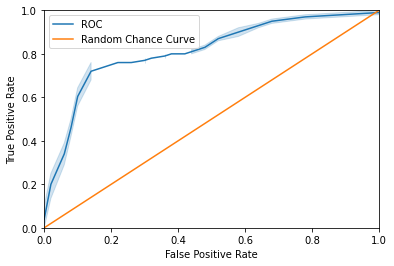

AUROC BLOSUM50 --> 0.8146 

BLOSUM62
--------


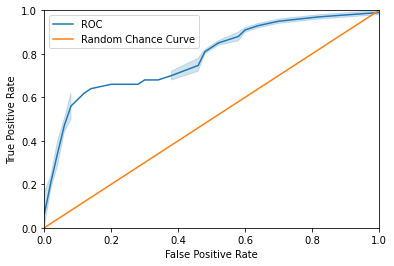

AUROC BLOSUM62 --> 0.7849999999999999 

PAM100
------


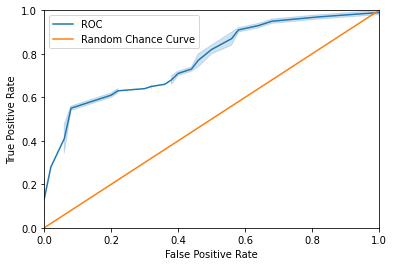

AUROC PAM100 --> 0.7744 

PAM250
------


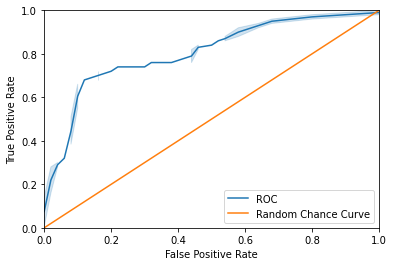

0it [00:00, ?it/s]

AUROC PAM250 --> 0.8056 



100it [01:09,  1.43it/s]
100it [01:20,  1.24it/s]
100it [01:11,  1.39it/s]
100it [01:15,  1.33it/s]


######## Local ########

BLOSUM50
--------


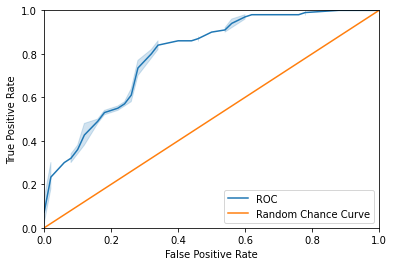

AUROC BLOSUM50 --> 0.7986 

BLOSUM62
--------


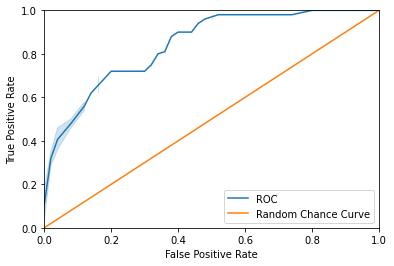

AUROC BLOSUM62 --> 0.8444 

PAM100
------


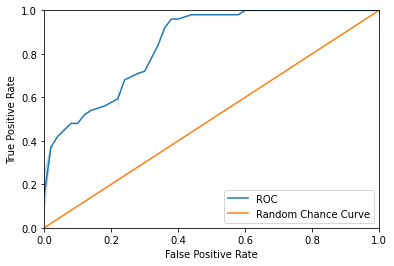

AUROC PAM100 --> 0.8452 

PAM250
------


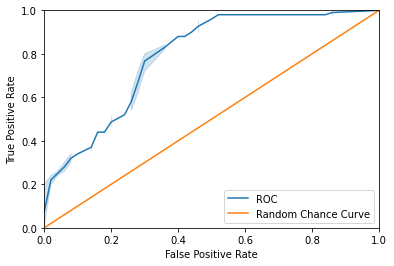

AUROC PAM250 --> 0.7924 



In [29]:
# Plotting ROC Curves for NeedlemanWunsch

# BLOSUM50
print('######## GLOBAL ########\n')
print('BLOSUM50')
print('--------')
nw_classifier_1.plot_roc()
print(f'AUROC BLOSUM50 --> {nw_classifier_1.roc_auc_score_} \n')

# BLOSUM62
print('BLOSUM62')
print('--------')
nw_classifier_2.plot_roc()
print(f'AUROC BLOSUM62 --> {nw_classifier_2.roc_auc_score_} \n')

# PAM100
print('PAM100')
print('------')
nw_classifier_3.plot_roc()
print(f'AUROC PAM100 --> {nw_classifier_3.roc_auc_score_} \n')

# PAM250
print('PAM250')
print('------')
nw_classifier_4.plot_roc()
print(f'AUROC PAM250 --> {nw_classifier_4.roc_auc_score_} \n')


# Plotting ROC Curves for SmithWaterman
# BLOSUM50
sw_aligner_1 = algs.SmithWaterman('./scoring_matrices/BLOSUM50.mat', best_gap_open, best_gap_extend)
sw_classifier_1 = Classifier(sw_aligner_1, pair_df, return_alignment=False)
sw_classifier_1.run_classification()
# print(f'AUROC BLOSUM50 --> {sw_classifier_1.roc_auc_score_} \n')

# BLOSUM62
sw_aligner_2 = algs.SmithWaterman('./scoring_matrices/BLOSUM62.mat', best_gap_open, best_gap_extend)
sw_classifier_2 = Classifier(sw_aligner_2, pair_df, return_alignment=False)
sw_classifier_2.run_classification()
# print(f'AUROC BLOSUM62 --> {sw_classifier_2.roc_auc_score_} \n')

# PAM100
sw_aligner_3 = algs.SmithWaterman('./scoring_matrices/PAM100.mat', best_gap_open, best_gap_extend)
sw_classifier_3 = Classifier(sw_aligner_3, pair_df, return_alignment=False)
sw_classifier_3.run_classification()
# print(f'AUROC PAM100 --> {sw_classifier_3.roc_auc_score_} \n')

# PAM250
sw_aligner_4 = algs.SmithWaterman('./scoring_matrices/PAM250.mat', best_gap_open, best_gap_extend)
sw_classifier_4 = Classifier(sw_aligner_4, pair_df, return_alignment=False)
sw_classifier_4.run_classification()
# print(f'AUROC PAM250 --> {sw_classifier_4.roc_auc_score_} \n')

# BLOSUM50
print('######## Local ########\n')
print('BLOSUM50')
print('--------')
sw_classifier_1.plot_roc()
print(f'AUROC BLOSUM50 --> {sw_classifier_1.roc_auc_score_} \n')

# BLOSUM62
print('BLOSUM62')
print('--------')
sw_classifier_2.plot_roc()
print(f'AUROC BLOSUM62 --> {sw_classifier_2.roc_auc_score_} \n')

# PAM100
print('PAM100')
print('------')
sw_classifier_3.plot_roc()
print(f'AUROC PAM100 --> {sw_classifier_3.roc_auc_score_} \n')

# PAM250
print('PAM250')
print('------')
sw_classifier_4.plot_roc()
print(f'AUROC PAM250 --> {sw_classifier_4.roc_auc_score_} \n')

These ROC curves suggest that the best performing matrix for the classification score according to the AUROC is BLOSUM50.

# Question 8

Based on these results, I believe the best algorithm is the NeedlemanWunsch algorithm using an affine-gap penelty scheme of 4 for both gap-opening and gap-extension. This in combination with the best penalty scheme being g-o 4 and g-e 4, suggests that these sequences are distantly related and more divergent. This is because BLOSUM50 is used for more strongly divergent protein sequences and the gap penalty scheme suggests small single base indels, which are more common in distant protein sequences than those that are close homologs.